<h3>Import</h3>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES=True
print(torch.cuda.get_device_name(0))
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


c:\Users\yeara\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NVIDIA GeForce RTX 2060


<h3> Check Image </h3>

(128, 128)


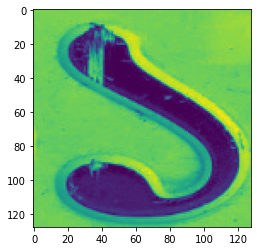

(194, 135, 3)


In [2]:
image = cv2.imread('cropped_patches_class/1/1_15.jpg', cv2.IMREAD_GRAYSCALE)
print(image.shape)
plt.imshow(image)
plt.show()

image = Image.open('cropped_patches/0_18.jpg')
image = np.array(image)
print(image.shape)


<h3>Split dataset into 80:20 and copy in corresponding class named subfolders inside train/val directory</h3>

In [ ]:
# import os 
# import shutil

# # Where all cropped pathces are saved in classes
# rootdir = 'cropped_patches_class'
# # Train directory
# train_dir = 'classification_dataset/train'
# # Validation directory
# validation_dir = 'classification_dataset/validation'
# # Training data ratio
# train_ratio = 80

# # Goes through all subdirectories in root directory
# for subdir, dir, files in os.walk(rootdir):
    
#     total_file_in_class = len(files)
#     train_file_count = (total_file_in_class * train_ratio) / 100
#     train_file_count = round(train_file_count)
#     validation_file_count = total_file_in_class - train_file_count
#     print(subdir+ " contains " + str(len(files)) + " images & train: " + str(train_file_count) + " val:" + str(validation_file_count)) 
#     sent_to_train = 0

#     for file in files:
#         #print (os.path.join(subdir, file))
#         class_name = file.split("_", 1)[0] # Requires for subfolder generation using class name
#         file_src = os.path.join(subdir, file)

#         if sent_to_train == train_file_count: # We send to validation now
#             file_dst = os.path.join(validation_dir, class_name, file)
#             destination_class_folder = os.path.join(validation_dir, class_name)
#         else:
#             file_dst = os.path.join(train_dir, class_name, file)
#             destination_class_folder = os.path.join(train_dir, class_name)
#             sent_to_train += 1 

#         pathExists = os.path.exists(destination_class_folder)
#         print(file_dst)
#         if pathExists:
#             shutil.copyfile(file_src, file_dst)
#         else:
#             os.makedirs(destination_class_folder)
            
               

In [32]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

In [33]:
img_transforms = transforms.Compose([
    transforms.Resize((64,64)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225] )
    ])

In [34]:
train_data_path = "classification_dataset/train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms, is_valid_file=check_image)
val_data_path = "classification_dataset/validation/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms, is_valid_file=check_image)

In [35]:
print("Train Data: " + str(len(train_data)))
print("Validation Data: " + str(len(val_data)))

Train Data: 290
Validation Data: 73


In [36]:
batch_size=8
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size) 

In [37]:
class SimpleNet(nn.Module):

    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(12288, 84)
        self.fc2 = nn.Linear(84, 50)
        self.fc3 = nn.Linear(50,15)
    
    def forward(self, x):
        x = x.view(-1, 12288)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [38]:
simplenet = SimpleNet()
optimizer = optim.Adam(simplenet.parameters(), lr=0.001)

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

simplenet.to(device)

SimpleNet(
  (fc1): Linear(in_features=12288, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=15, bias=True)
)

In [39]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [40]:
train(simplenet, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=50, device=device)

Epoch: 1, Training Loss: 3.60, Validation Loss: 2.00, accuracy = 0.49
Epoch: 2, Training Loss: 2.32, Validation Loss: 0.93, accuracy = 0.68
Epoch: 3, Training Loss: 1.01, Validation Loss: 0.64, accuracy = 0.79
Epoch: 4, Training Loss: 0.47, Validation Loss: 0.47, accuracy = 0.88
Epoch: 5, Training Loss: 0.22, Validation Loss: 0.48, accuracy = 0.88
Epoch: 6, Training Loss: 0.12, Validation Loss: 0.25, accuracy = 0.93
Epoch: 7, Training Loss: 0.21, Validation Loss: 0.52, accuracy = 0.88
Epoch: 8, Training Loss: 0.23, Validation Loss: 0.48, accuracy = 0.89
Epoch: 9, Training Loss: 0.17, Validation Loss: 0.40, accuracy = 0.93
Epoch: 10, Training Loss: 0.07, Validation Loss: 0.33, accuracy = 0.89
Epoch: 11, Training Loss: 0.03, Validation Loss: 0.31, accuracy = 0.92
Epoch: 12, Training Loss: 0.01, Validation Loss: 0.31, accuracy = 0.92
Epoch: 13, Training Loss: 0.00, Validation Loss: 0.28, accuracy = 0.93
Epoch: 14, Training Loss: 0.00, Validation Loss: 0.28, accuracy = 0.93
Epoch: 15, Trai

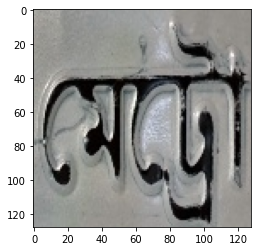

Metro


In [51]:
labels = ['zero','one','two','three',
            'four', 'five', 'six', 'seven',
            'eight', 'nine', 'CHA', 'Dhaka',
            'GA', 'GHA', 'Metro']

img = Image.open("classification_dataset/validation/Metro/Metro_361.jpg") 
image = cv2.imread("classification_dataset/validation/Metro/Metro_361.jpg")
plt.imshow(image)
plt.show()
img = img_transforms(img).to(device)
img = torch.unsqueeze(img, 0)

simplenet.eval()
prediction = F.softmax(simplenet(img), dim=1)
prediction = prediction.argmax()
print(labels[prediction]) 